Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:

!ls /content/gdrive/

MyDrive


In [ ]:
!ls -1 /content/gdrive/MyDrive/simpsons_dataset/journey-springfield.zip

In [ ]:
!unzip -q /content/gdrive/MyDrive/simpsons_dataset/journey-springfield.zip

In [ ]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


Все подгрузилось верно, начинаем работу с архитектурой

In [ ]:
import time
import os
import pickle
from tqdm.autonotebook import trange, tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from PIL import Image

import torchvision
from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder

<ipython-input-8-4a14b215fdc9>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:

# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

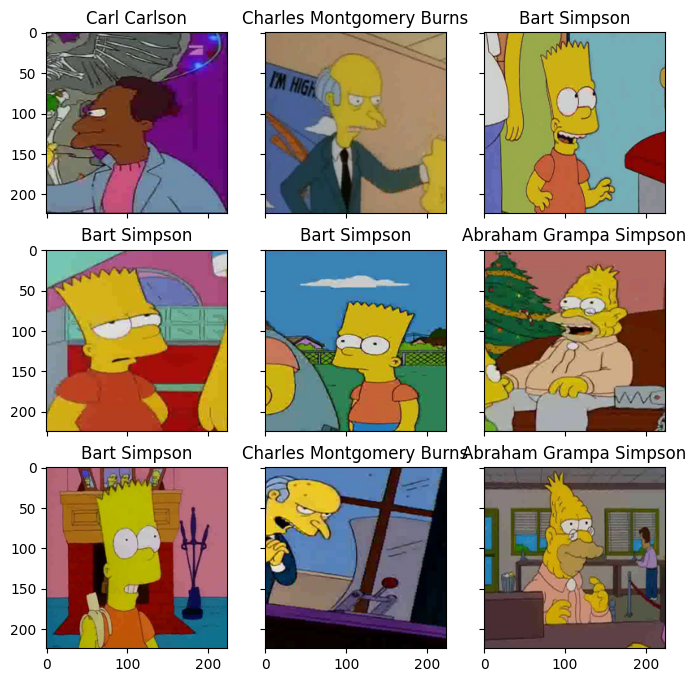

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

балансировка классов

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # классы train + val
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
print_dct(dct_path_train)

abraham_grampa_simpson	[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0279.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0582.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0366.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0200.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0078.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0330.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0224.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0475.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0173.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0647.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0851.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0113.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0520.jpg'), PosixPath('train/simpsons_d

In [ ]:
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [ ]:
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [ ]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [ ]:
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

NN

In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride = 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride = 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding = 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding = 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=512, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=384, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 1)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 1)
        )

        self.classifier = nn.Sequential(
          nn.Linear(384 * 11 * 11, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(4096, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = 1e-5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
from torchvision.models import vgg16, VGG16_Weights
n_classes = len(np.unique(train_val_labels))
model = SimpleCnn(n_classes).to(DEVICE)
#model = models.vgg16(weights = VGG16_Weights.DEFAULT).to(DEVICE)
print("we will classify :{}".format(n_classes))

we will classify :42


In [ ]:
print(model)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv6): Sequential(
    (0): Conv2d(512, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [ ]:
# посмотрим какие параметры нейросети мы учим
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.0.weight
	 conv1.0.bias
	 conv2.0.weight
	 conv2.0.bias
	 conv3.0.weight
	 conv3.0.bias
	 conv4.0.weight
	 conv4.0.bias
	 conv5.0.weight
	 conv5.0.bias
	 conv6.0.weight
	 conv6.0.bias
	 conv7.0.weight
	 conv7.0.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=5, batch_size=128)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.005221194480750984

Epoch 001 train_loss: 0.0052     val_loss 1.0495 train_acc 0.9988 val_acc 0.8750
loss 0.003434485471710436

Epoch 002 train_loss: 0.0034     val_loss 1.1157 train_acc 0.9991 val_acc 0.8741
loss 0.0009346408929520643

Epoch 003 train_loss: 0.0009     val_loss 1.1656 train_acc 0.9998 val_acc 0.8760
loss 0.000994030483544962

Epoch 004 train_loss: 0.0010     val_loss 1.1830 train_acc 0.9997 val_acc 0.8768
loss 0.0016375109289094299

Epoch 005 train_loss: 0.0016     val_loss 1.2389 train_acc 0.9995 val_acc 0.8764


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

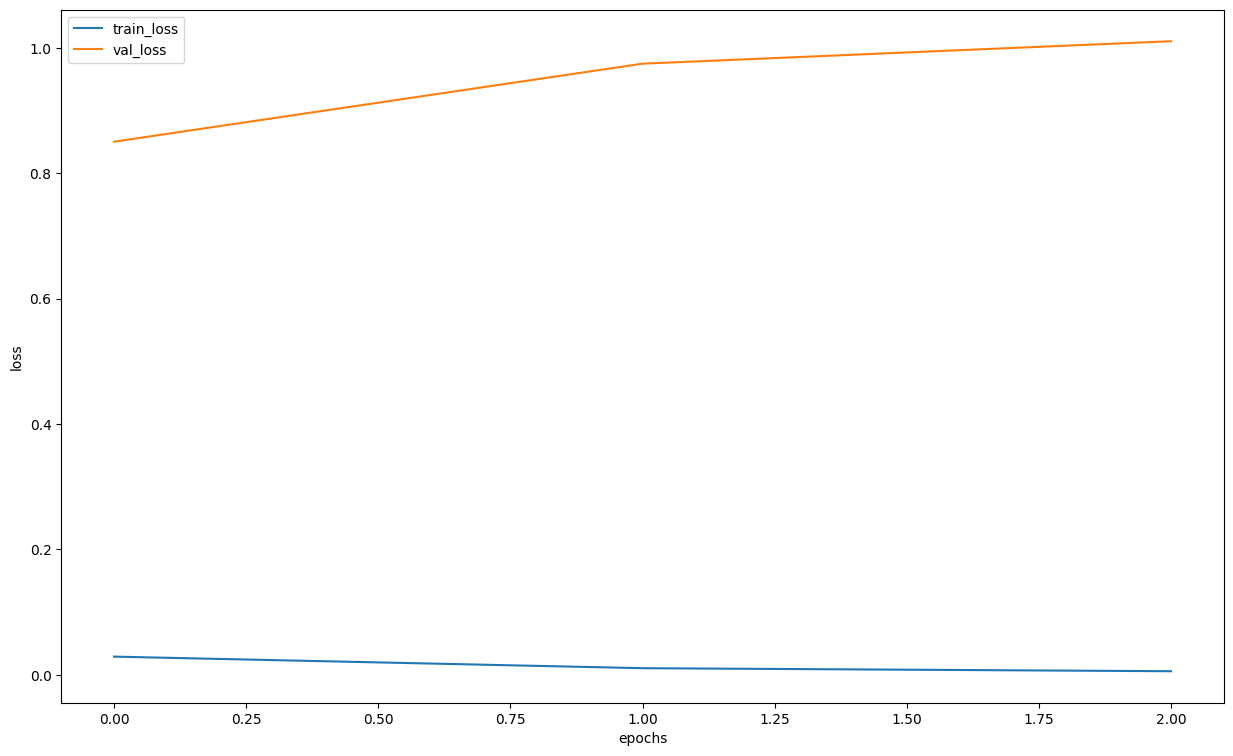

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average="micro")

0.83

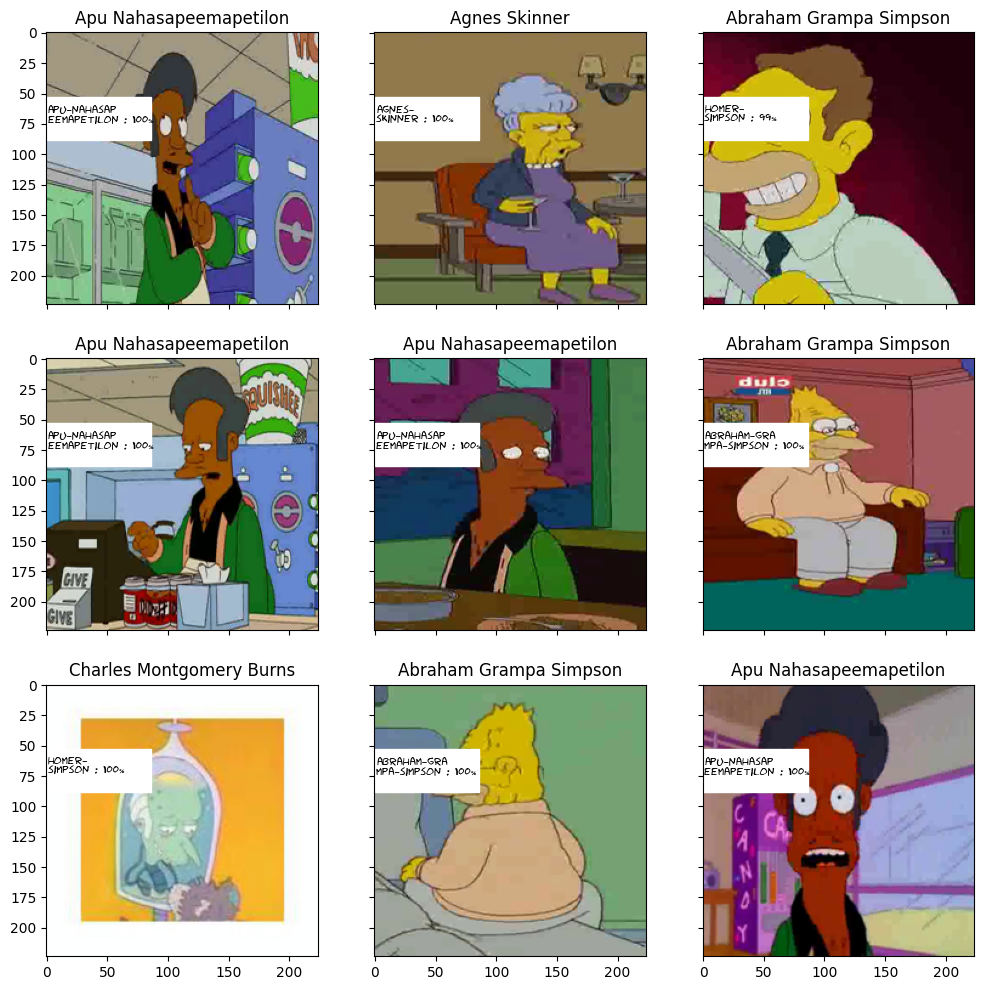

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

TEST

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('submit.csv', index=False)